<h1 align="center">Income Prediction Factors: Education, ITPA Test, Gender, and High School GPA.</h1>

In this project, my goal is to investigate how person's background factors (education, gender, high school GPA, and ITPA intelligence test score) affect income. The dataset used in this project can be found from a link in the references section.

<br>

In [1]:
import pymc as pm
import bambi as bmb
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
ltd = pd.read_csv('/Users/herrakaava/Documents/Bayesian-Statistics-1/aineistot/FSD2076/Study/Data/life-trajectory-data.csv',
                  index_col=0)

In [3]:
ltd = ltd.rename(columns={'arvosana': 'GPA',
                          'sukupuoli': 'gender',
                          'koulutustaso': 'education',
                          'tulot': 'income'})

In [5]:
mapping_dict_gender = {'Mies': 'Male', 'Nainen': 'Female'}
mapping_dict_education = {'Korkeintaan toisen asteen koulutus': 'at most secondary education',
                          'Alempi korkeakouluaste tai alin korkea-aste': "Bachelor's degree",
                          'Ylempi korkeakouluaste': "Master's degree"}

In [8]:
ltd['gender'] = ltd['gender'].replace(mapping_dict_gender)
ltd['education'] = ltd['education'].replace(mapping_dict_education)

In [9]:
ltd.head()

,GPA,gender,education,income,ITPA
1,9.2,Male,Master's degree,30027.263263,37
2,8.1,Female,Bachelor's degree,19291.996105,28
3,7.0,Male,at most secondary education,31707.124272,31
4,8.0,Female,at most secondary education,6992.080000,27
5,8.9,Female,at most secondary education,17189.815212,40


In [10]:
ltd.isna().any()

GPA          False
gender       False
education    False
income       False
ITPA         False
dtype: bool

In [11]:
ltd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243 entries, 1 to 243
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GPA        243 non-null    float64
 1   gender     243 non-null    object 
 2   education  243 non-null    object 
 3   income     243 non-null    float64
 4   ITPA       243 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 11.4+ KB


For large sample size n the posterior mean converges to the maximum likelihood estimate (and the posterior distribution to normal distribution centered around the MLE $\, \rightarrow \,$ this is known as the asymptotic normality of the posterior distribution), so for large n one can ignore specifying priors. However, in this case, since the sample size is only 243, it is essential that priors are specified.

<h2 align="left">Bayesian Workflow</h2>

Next, a model of interest will be initiated for development. These models will commence with simplicity and will be subject to iterative improvements. The following workflow is a strong choice for adoption during the model development process.
1. Plot the data
2. Build and fit a model
3. Run a prior predictive check
5. Assess convergence
6. Run a posterior predictive check
7. Improve the model

<h3 align="left">1. Plot the data</h3>

Here, the association of the predictors with the response variable will be evaluated visually.

In [10]:
# To visualize ITPA test score vs. income, I am going to cluster the groups.
ltd['ITPA'].unique()

array([37, 28, 31, 27, 40, 39, 15, 38, 41, 32, 46, 35, 29, 44, 34, 43, 45,
       53, 50, 33, 30, 48, 42, 51, 36, 22, 19, 49, 21, 47, 25, 23])

In [11]:
clustered_ITPA = pd.cut(ltd['ITPA'],
                        bins=[14, 24, 34, 44, 54],
                        labels=['15-24', '25-34', '35-44', '45-53'],
                        right=True)
ITPA_income = pd.DataFrame({'ITPA_clustered': clustered_ITPA,
                            'Income': ltd['income']})

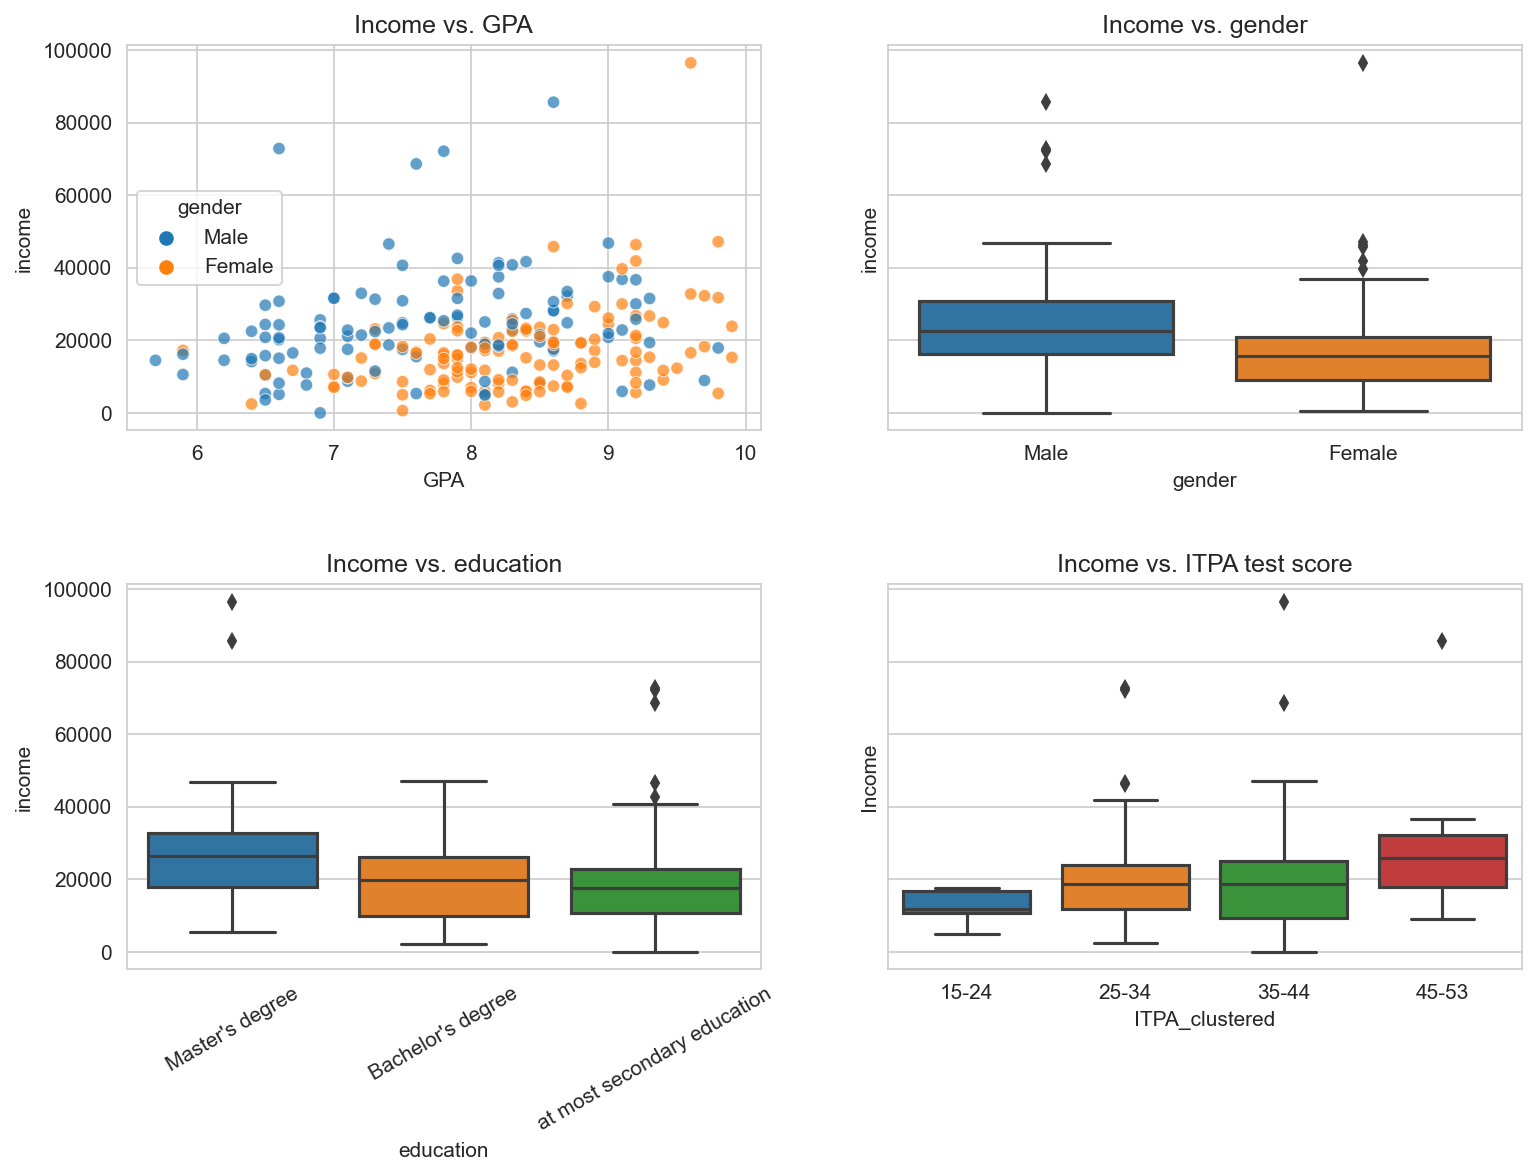

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharey=True, dpi=150)
sns.set_style('whitegrid')

sns.scatterplot(x='GPA', 
                y='income', 
                hue='gender',
                ax=ax[0, 0],
                alpha=0.7,
                data=ltd)
ax[0, 0].set_title('Income vs. GPA', size=12)

sns.boxplot(x='gender', 
            y='income',
            ax=ax[0, 1],
            data=ltd)
ax[0, 1].set_title('Income vs. gender', size=12)

sns.boxplot(x='education', 
            y='income',
            ax=ax[1, 0],
            data=ltd)
ax[1, 0].set_xticklabels(labels=ltd['education'].unique(), rotation=30)
ax[1, 0].set_title('Income vs. education', size=12)

sns.boxplot(x='ITPA_clustered', 
            y='Income',
            ax=ax[1, 1],
            data=ITPA_income)
ax[1, 1].set_title('Income vs. ITPA test score', size=12)

fig.subplots_adjust(hspace=0.4)
warnings.filterwarnings("ignore", category=FutureWarning)

Based on the visual inspections, it seems that 
- The visual inspection suggests a weak or minimal association between GPA and income.
- Men tend to earn higher incomes than women.
- Individuals with higher levels of education generally enjoy higher incomes compared to those with lower levels of education.
- Children who achieved higher scores on the ITPA intelligence test tend to earn higher salaries in adulthood.

Next, let us inspect the distributions of the predictors.

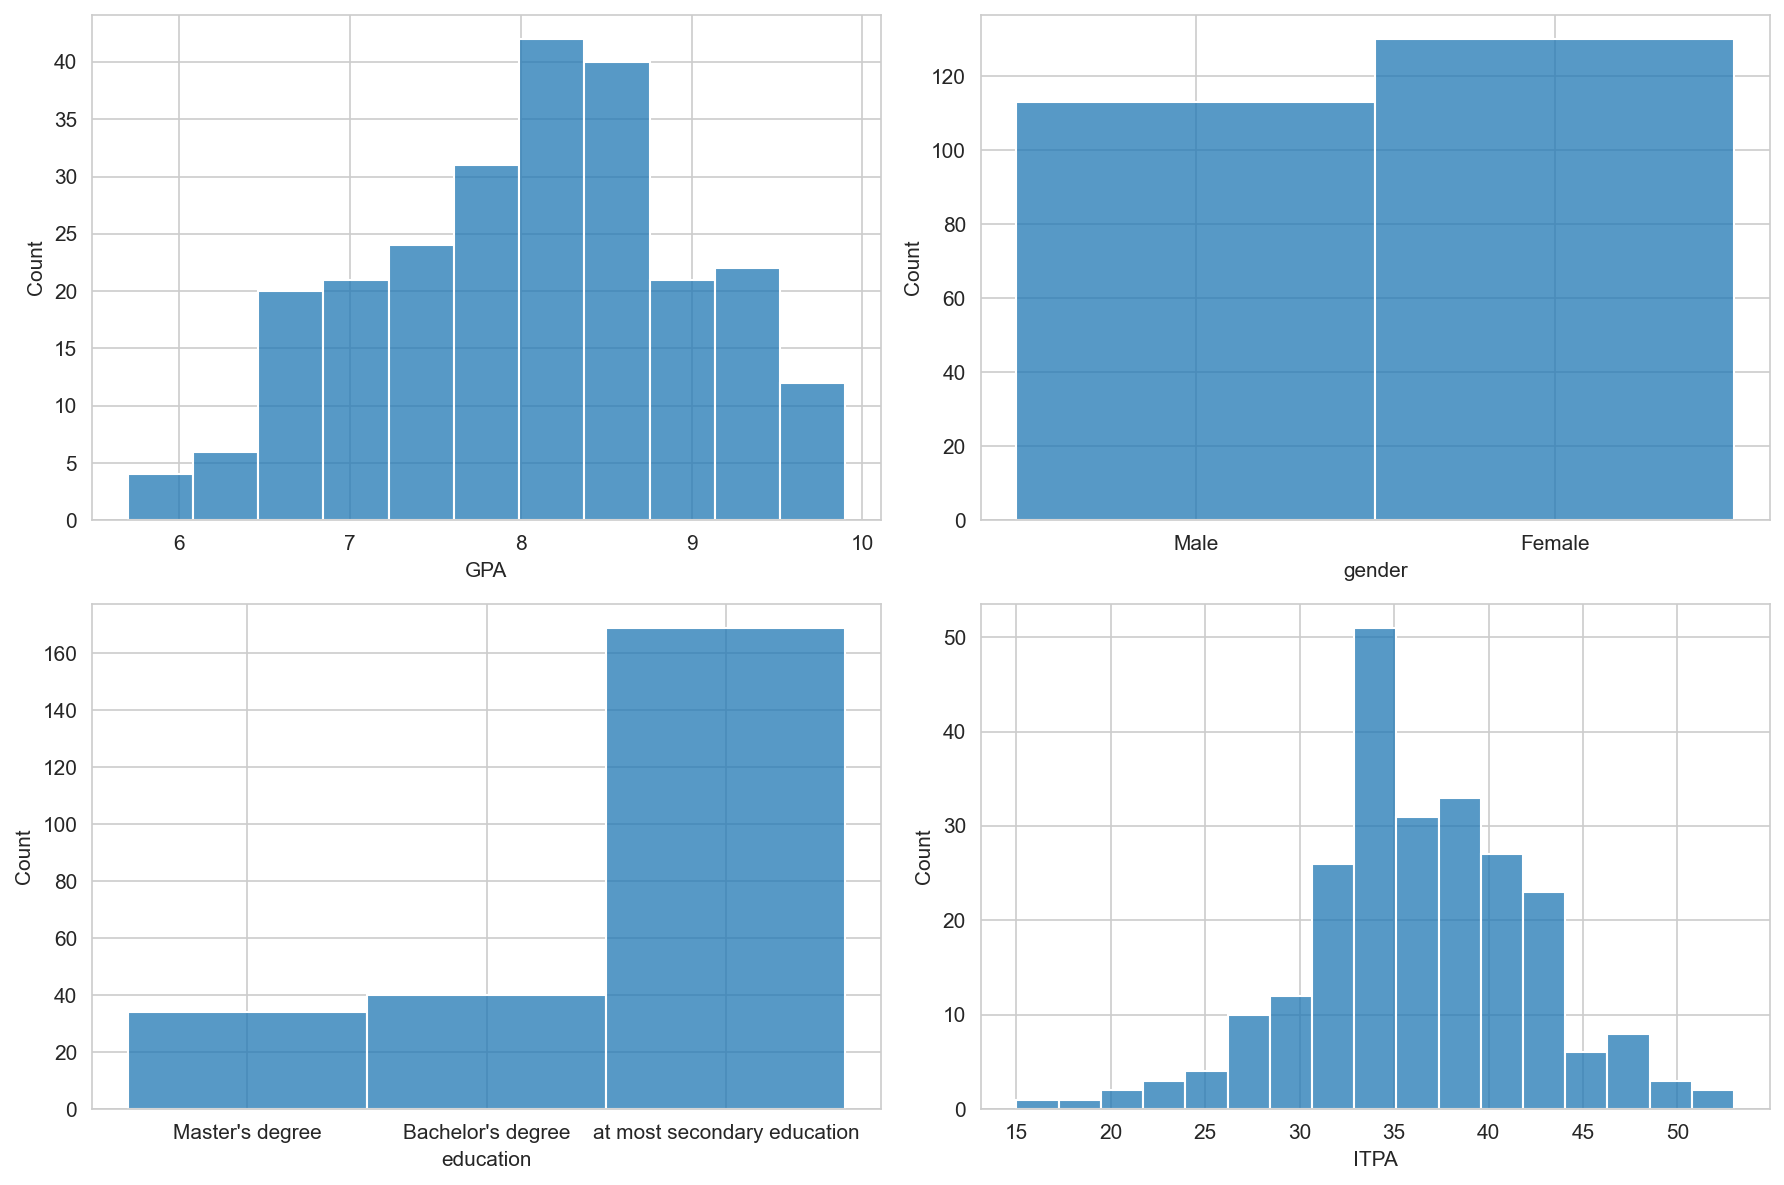

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), dpi=150)
ax = ax.flatten()
i=0

for col in ltd.columns.drop('income'):
    sns.histplot(ltd[col], ax=ax[i])
    i += 1

plt.tight_layout()

Now, the distribution of the response.

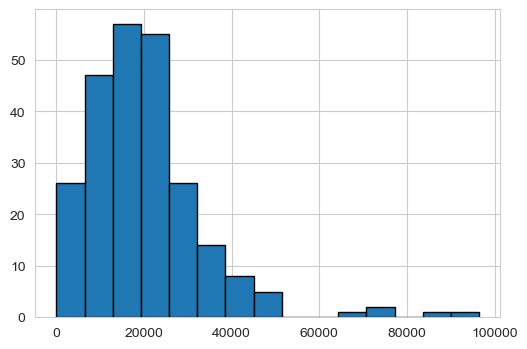

In [15]:
plt.figure(figsize=(6, 4), dpi=100)
plt.hist(ltd['income'], bins=15, edgecolor='black');

Based on the visual inspections and the nature of the response variable, a Bayesian linear regression is a strong choice for the model.

<br>

<h3 align="left">2. Build and fit a model</h3>

First, let's build a simple model with only one predictor, GPA, and improve the model later on. Since income (the response variable) can only be a positive real number, I am going to choose a gamma distribution (with a log link) for the likelihood.

In [16]:
model_simple = bmb.Model('income ~ GPA', family='gamma', link='log', data=ltd)

In [17]:
idata_simple = model_simple.fit(draws=1000, 
                                tune=1000,
                                idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [income_alpha, Intercept, GPA]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


- Notice that we need to explicitly ask for the inclusion of the log-likelihood values into the inference data object.
- The importance of this becomes evident later on when performing model comparison via cross-validation and WAIC.

In [16]:
model_simple

       Formula: income ~ GPA
        Family: gamma
          Link: mu = log
  Observations: 243
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 21.8656)
            GPA ~ Normal(mu: 0.0, sigma: 2.6986)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

<h3 align="left">3. Run a prior predictive check</h3>

Without even fitting the model to the data, one can generate new potential data from the priors. A prior predictive check allows one to make sure the model can generate the types of data one expects to see based on the data available.

The workflow for prior predictive check is as follows:

1. Pick a point from the prior $\, \theta_i \,$
2. Generate a data set $\, x_i \sim f(\theta_i) \,$ where f is the likelihood function.
3. Rinse and repeat n times.

In [18]:
model_simple_prior_preds = model_simple.prior_predictive(draws=500)

Sampling: [GPA, Intercept, income, income_alpha]


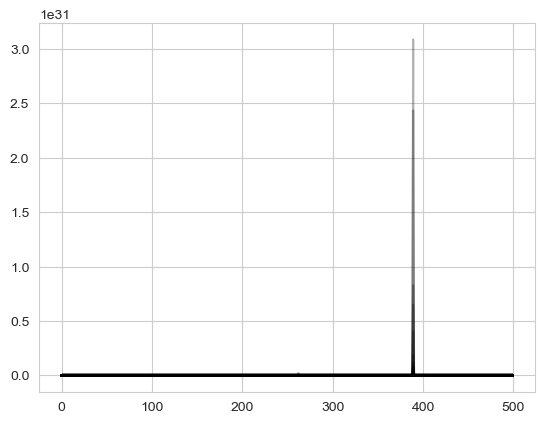

In [19]:
for sample in model_simple_prior_preds['prior_predictive']['income']:
    plt.plot(sample, alpha=0.3, color='black');

- The prior predictive results are absurd.

<h3 align="left">4. Asses convergence</h3>

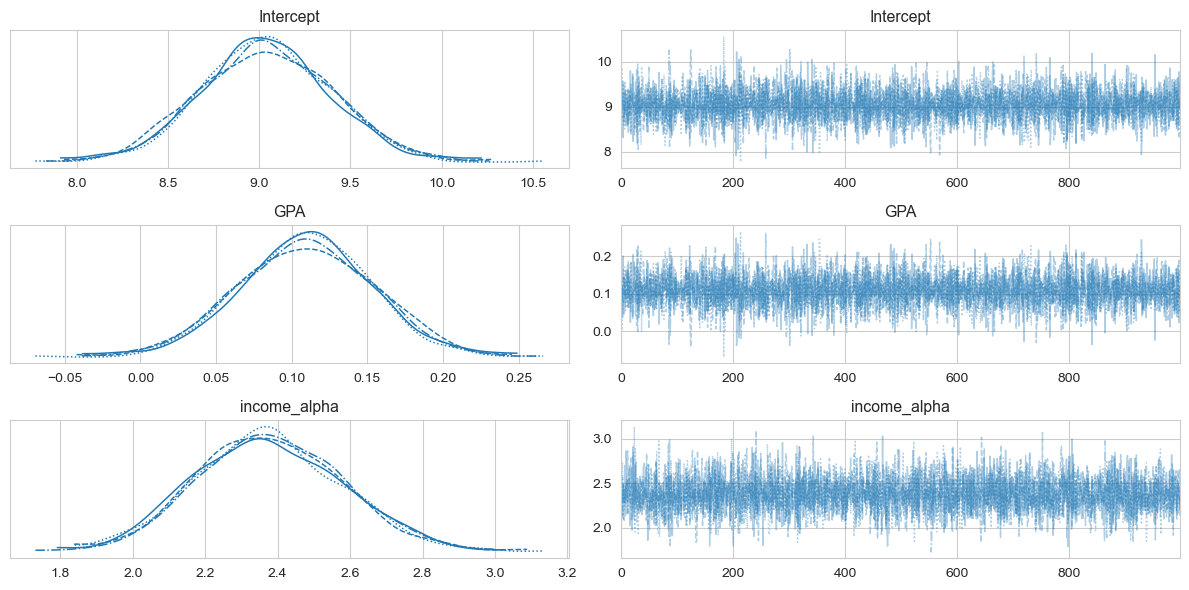

In [20]:
az.plot_trace(idata_simple)
plt.tight_layout();

In [21]:
az.summary(idata_simple)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,9.040,0.359,8.368,9.693,0.004,0.003,6756.0,3152.0,1.0
GPA,0.109,0.044,0.023,0.188,0.001,0.000,6619.0,3181.0,1.0
income_alpha,2.377,0.203,2.002,2.760,0.002,0.002,6835.0,3063.0,1.0


- The convergence of the simple model seems fine (r_hat < 1.01).

<h3 align="left">5. Run a posterior predictive check</h3>

In [22]:
model_simple.predict(idata_simple, kind='pps')

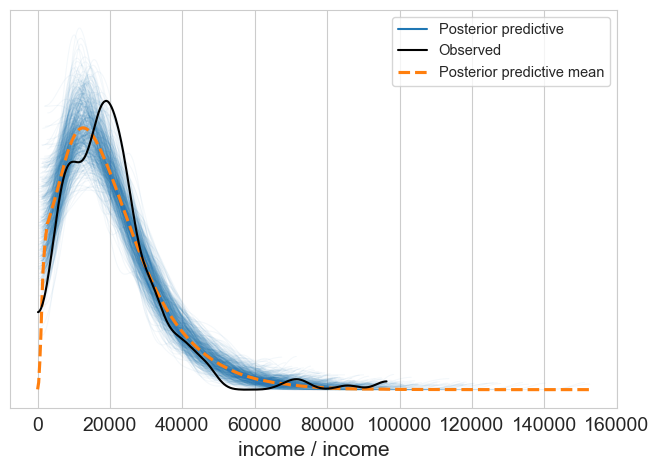

In [23]:
ax = az.plot_ppc(idata_simple, alpha=0.05, mean=True, num_pp_samples=500)
plt.tight_layout();

- The posterior predictive mean deviates from the observed data quite a lot.

Next, I will add more predictors and weakly informative priors to see if this has impact on the results.

<h3 align="left">2. Build and fit a model</h3>

In [12]:
full_model = bmb.Model('income ~ GPA + gender + education + ITPA', 
                       family='gamma', 
                       link='log', 
                       data=ltd)

In [13]:
# Weakly informative priors
priors = {
    'Intercept': bmb.Prior('Normal', mu=0, sigma=10),
    'GPA': bmb.Prior('Normal', mu=0, sigma=10),
    'gender': bmb.Prior('Normal', mu=0, sigma=10),
    'education': bmb.Prior('Normal', mu=0, sigma=10),
    'ITPA': bmb.Prior('Normal', mu=0, sigma=10)
}

In [14]:
# Set the priors
full_model.set_priors(priors)

In [15]:
# Fit the model
idata_full = full_model.fit(draws=1000, 
                            tune=1000,
                            idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [income_alpha, Intercept, GPA, gender, education, ITPA]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [17]:
full_model

       Formula: income ~ GPA + gender + education + ITPA
        Family: gamma
          Link: mu = log
  Observations: 243
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 10.0)
            GPA ~ Normal(mu: 0.0, sigma: 10.0)
            gender ~ Normal(mu: 0.0, sigma: 10.0)
            education ~ Normal(mu: 0.0, sigma: 10.0)
            ITPA ~ Normal(mu: 0.0, sigma: 10.0)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

<h3 align="left">3. Run a prior predictive check</h3>

In [18]:
full_model_prior_preds = full_model.prior_predictive(draws=500)

Sampling: [GPA, ITPA, Intercept, education, gender, income, income_alpha]


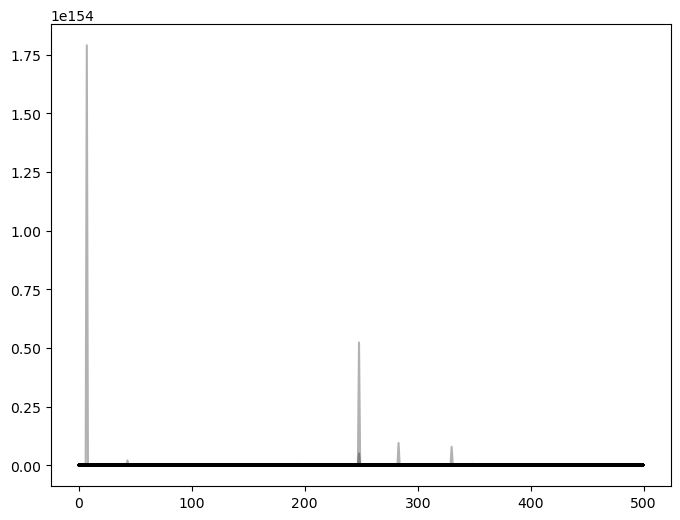

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
for sample in full_model_prior_preds['prior_predictive']['income']:
    ax.plot(sample, alpha=0.3, color='black');

- Again, these make no sense whatsoever.

<h3 align="left">4. Asses convergence</h3>

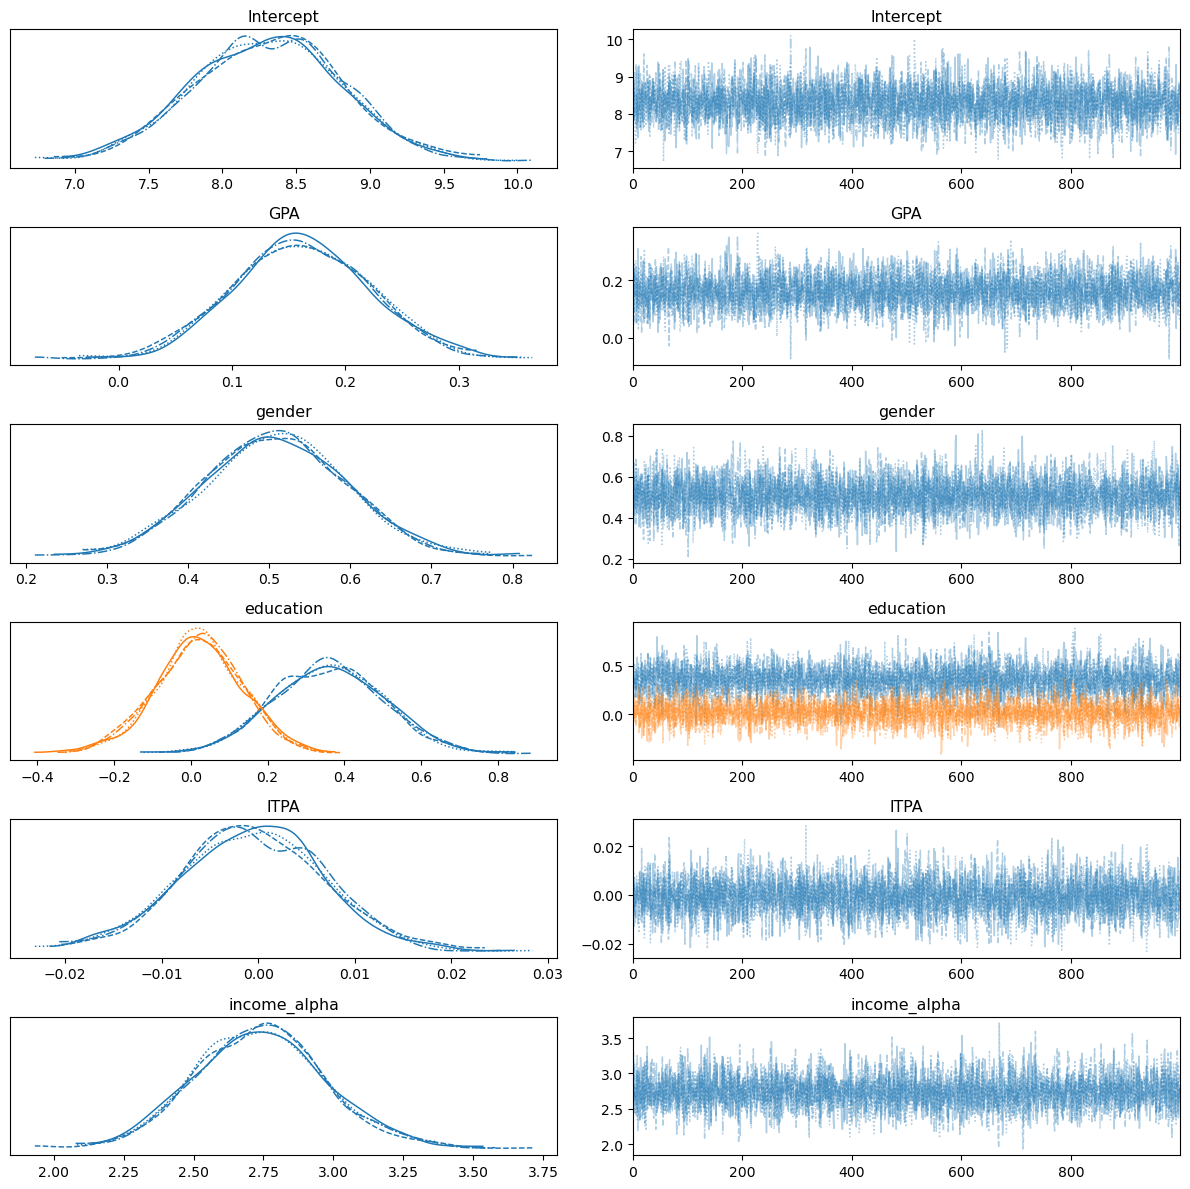

In [20]:
az.plot_trace(idata_full)
plt.tight_layout();

In [22]:
stats = az.summary(idata_full)
stats

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,8.309,0.499,7.319,9.191,0.007,0.005,4887.0,3224.0,1.0
GPA,0.162,0.059,0.052,0.271,0.001,0.001,4277.0,3283.0,1.0
gender[Male],0.508,0.086,0.345,0.664,0.001,0.001,5432.0,3347.0,1.0
education[Master's degree],0.360,0.145,0.080,0.617,0.002,0.002,4486.0,3007.0,1.0
education[at most secondary education],0.020,0.114,-0.202,0.233,0.002,0.002,4188.0,3104.0,1.0
ITPA,-0.001,0.007,-0.014,0.014,0.000,0.000,5249.0,3257.0,1.0
income_alpha,2.739,0.234,2.298,3.182,0.003,0.002,5301.0,2945.0,1.0


- The convergence seems fine (r_hat < 1.01).

<h3 align="left">5. Run a posterior predictive check</h3>

In [33]:
full_model.predict(idata_full, kind='pps')

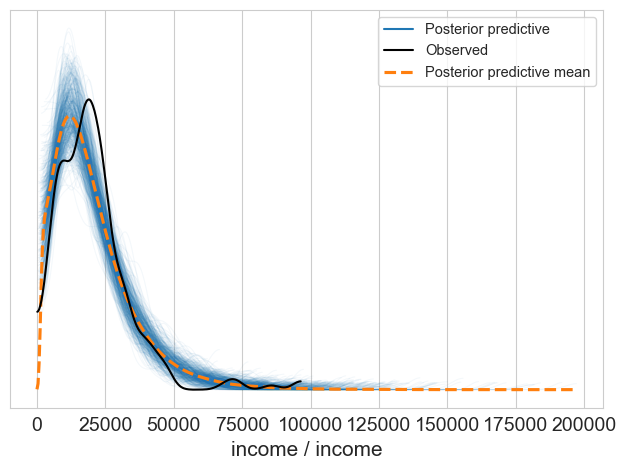

In [34]:
ax = az.plot_ppc(idata_full, alpha=0.05, mean=True, num_pp_samples=500)
plt.tight_layout();

- When comparing the posterior predictive results of the simple model, which includes only one predictor, to those of the full model, which incorporates all available predictors, it becomes evident that the full model more accurately captures the observed data's behavior.

Next, I will compare the models via cross-validation.

<h3><a href="https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html">Model comparison</a></h3>

**Leave-one-out Cross-validation (LOO)**

LOO cross-validation is an estimate of the out-of-sample predictive fit. In cross-validation, the data are repeatedly partitioned into training and holdout sets, iteratively fitting the model with the former and evaluating the fit with the holdout data. Vehtari et al. (2016) introduced an efficient computation of LOO from MCMC samples (without the need for re-fitting the data). This approximation is based on importance sampling. The importance weights are stabilized using a method known as Pareto-smoothed importance sampling (PSIS).

One can compare models based on their expected log pointwise predictive density (ELPD) by using the function **compare()** provided by the ArviZ library. This function is similar (or equivalent) to R's loo_compare() function. The ELPD is estimated either by Pareto smoothed importance sampling leave-one-out
cross-validation (LOO) or by using the widely applicable information criterion (WAIC).

$$ elpd_{loo} = \sum\limits_{i=1}^{n} log \, p (y_i|y_{-i}), $$

where $\, y_{-i} \,$ refers to the data without the observation $\, y_{i} \,$ (n is the size of the data).

In order to compute LOO (or WAIC), ArviZ needs to acces to the model's element-wise log-likelihood for every posterior sample. Notice that we need to explicitly ask for the inclusion of the log-likelihood values into the inference data object when fitting the model (this was done previously).

In [35]:
# Compare the models via LOO
az.compare({"simple_model": idata_simple, "full_model": idata_full}, ic="loo")

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
full_model,0,-2596.814666,8.158668,0.00000,0.932675,16.589388,0.000000,False,log
simple_model,1,-2614.351406,4.503434,17.53674,0.067325,15.438340,6.142958,False,log


- A bigger **elpd_loo** value indicates a better fit to the data.
- Therefore, based on both the leave-one-out (LOO) comparison and the posterior predictive checks, it is evident that the full model, which includes all available predictors, outperforms the simple model.

<h3 align="left">Model structure and interpretation</h3>

**Likelihood:**

$$\, y_i|\theta \sim Gamma(\alpha, \beta) \,$$


**Linear predictor**:

$$log(\mu) = \beta_0 + \beta_1 \, GPA \, + \, \beta_2 \, gender \, + \, \beta_3 \, education \, + \, \beta_4 \, ITPA \, + \, \epsilon_i, \quad \epsilon_i \sim N(0, \sigma^2), $$

where the weakly informative priors $\, \beta_0, \beta_1, \beta_2, \beta_3, \beta_4 \sim N(0, 10^2).$

In [27]:
np.exp(stats[['mean', 'sd', 'hdi_3%', 'hdi_97%']])

,mean,sd,hdi_3%,hdi_97%
Intercept,4060.250702,1.647073,1508.694521,9808.454531
GPA,1.175860,1.060775,1.053376,1.311275
gender[Male],1.661964,1.089806,1.411990,1.942547
education[Master's degree],1.433329,1.156040,1.083287,1.853360
education[at most secondary education],1.020201,1.120752,0.817095,1.262381
ITPA,0.999000,1.007025,0.986098,1.014098
income_alpha,15.471506,1.263644,9.954254,24.094895


With linear regression, the interpretation of the results is pretty straightforward. However, the interpretation for a continuous predictor variable and a categorical predictor variable is somewhat different. 

Let $\, X_c \,$ be a categorical predictor variable representing gender and $\, b_c \,$ its regression coefficient, and let Y be the response variable. Now, $\, b_c \,$ is interpreted as the difference in Y for each one unit difference in $\, X_c \,$, when all of the other predictor variables are held constant. However, since $\, X_c \,$ is a categorical variable coded as 0 or 1 (under the hood), a one unit difference represents switching from one category to another. This means that $\, b_c \,$ is the average difference in Y between the category for which $\, X_c \,$ = 0 (the reference group, females in our case), and the category for which $\, X_c \,$ = 1 (the comparison group, males in our case).

The $\, \beta \,$ coefficient of a continuous predictor variable can be interpreted such that it represents the difference in the response variable for each one unit difference in the continuous predictor variable in question, while holding the other predictor variables constant.

**Intercept:**

A female, who has a GPA of zero, has a bachelor's degree (the reference group of education), and scored an ITPA test result of zero, is expected to have a salary of 4060€.

**GPA:**

A one unit increase in GPA increases income by approximately 1.176 units.

**gender[Male]:**

Males are expected to have an income of approximately 1.662 units higher.

**ITPA:**

A one unit increase in the ITPA intelligence test is by average going to affect income by 0.999 units.

Highest density intervals (HDIs) provide a way to express uncertainty about a parameter estimate. They represent a range of values for a parameter that contains a specified percentage of the posterior distribution.

The 94% highest density interval for each corresponding regression coefficient can be interpreted such that there is a 94% probability that the true parameter value falls within this interval, with 3% of the probability mass in the lower tail and 3% in the upper tail.

<br>

In [35]:
# Save the model
az.to_netcdf(data=idata_full, filename='full_model_results.nc')

'full_model_results.nc'

In [37]:
# Load the model (and save it to a variable)
idata_load = az.from_netcdf('full_model_results.nc')

<br>

<h3 align="left">References</h3>

Kuusinen, Jorma (Jyväskylän yliopisto): Elämänkulku 1971-2002 [sähköinen tietoaineisto]. Versio 2.0 (2018-07-18). Yhteiskuntatieteellinen tietoarkisto [jakaja]. http://urn.fi/urn:nbn:fi:fsd:T-FSD2076